In [115]:
from gmplot import gmplot
from tqdm import tqdm
from typing import NamedTuple, List
from collections import defaultdict
import osmium as o
import geopy.distance
import sys
import random
from functools import reduce
import srtm

elevation = srtm.get_data()

In [14]:
def window(iterable, size=2):
    i = iter(iterable)
    win = []
    for e in range(0, size):
        win.append(next(i))
    yield win
    for e in i:
        win = win[1:] + [e]
        yield win

In [142]:
class Node(NamedTuple):
    id: int
    lat: float
    lon: float
        
class ElevationChange(NamedTuple):
    gain: float
    loss: float
    
    @classmethod
    def from_nodes(cls, nodes: List[Node]):
        gain = 0
        loss = 0
        for n1, n2 in window(nodes):
            e1 = elevation.get_elevation(n1.lat, n1.lon)
            e2 = elevation.get_elevation(n2.lat, n2.lon)
            if e2 > e1:
                gain += e2 - e1
            else:
                loss += e1 - e2
        return cls(gain, loss)
            
    
        
class Trail:
    def __init__(self, nodes, id, name):
        self.nodes = nodes
        self.id = id
        self.name = name
        self._length = None
        self._reversed = None

    def _length(self):
        dists = [geopy.distance.great_circle((a.lat, a.lon),(b.lat, b.lon)) for (a,b) in window(self.nodes)]
        return reduce(lambda x,y:x+y, dists)
    
    @property
    def length(self):
        if self._length is None:
            dists = [geopy.distance.great_circle((a.lat, a.lon),(b.lat, b.lon)) for (a,b) in window(self.nodes)]
            self._length = reduce(lambda x,y:x+y, dists)
        return self._length
    

    @classmethod/
    def from_way(cls, way):
        nodes = []
        id = str(way.id)
        for node in way.nodes:
            n = Node(node.ref, node.lat, node.lon)
            nodes.append(n)
        
        if way.tags.get('name'):
            name = way.tags['name']
        else:
            name = 'unamed'
        return cls(nodes=nodes, id=id, name=name)
    
    def split_at(self, idxs):
        start_idx = 0
        result = []
        for seg_num, idx in enumerate(idxs):
            new_nodes = self.nodes[start_idx:idx+1]
            new_id = f'{self.id}-{seg_num}/{len(idxs)}'
            result.append(Trail(nodes=new_nodes, id=new_id, name=self.name))
            start_idx = idx
        
        final_nodes = self.nodes[start_idx:]
        if final_nodes == []:
            assert 'Unexpected empty final nodes'
        result.append(Trail(nodes=final_nodes, id=f'{self.id}-{len(idxs)}/{len(idxs)}', name=self.name))
        verify_identical_nodes([self], result)
        return result
    
    def reverse(self):
        if self._reversed is None:
             self._reversed = Trail(list(reversed(self.nodes)), self.id, self.name)
        return self._reversed
        
    def draw(self, gmap, color=None):
        lats = [n.lat for n in self.nodes]
        lons = [n.lon for n in self.nodes]
        color = color or random.choice(list(gmap.html_color_codes.keys()))
        gmap.plot(lats, lons, color, edge_width=5)

In [16]:
TRAIL = set(['path', 'footway', 'track', 'trail', 'pedestrian'])

def is_trail(way):
    return 'highway' in way.tags and way.tags['highway'] in TRAIL

class TrailLoader(o.SimpleHandler):
    def __init__(self):
        super(TrailLoader, self).__init__()
        self.trails = {}
        self.highway_types = set()
        self.non_trail_nodes = set()

    def way(self, w):
        if 'highway' in w.tags:
            self.highway_types.add(w.tags['highway'])
            if is_trail(w):
                try:
                    self.trails[w.id] = Trail.from_way(w)
                except o.InvalidLocationError:
                    # A location error might occur if the osm file is an extract
                    # where nodes of ways near the boundary are missing.
                    print("WARNING: way %d incomplete. Ignoring." % w.id)
            else:
                node_ids = [n.ref for n in w.nodes]
                self.non_trail_nodes.update(node_ids)
            

In [17]:
def filter_trails(here, max_dist_km, trails: List[Trail]):
    for trail in trails:
        trail_start = (trail.nodes[0].lat, trail.nodes[0].lon)
        dist_from_here = geopy.distance.great_circle(here, trail_start).km
        if dist_from_here < max_dist_km:
            yield trail

In [18]:
rlh = TrailLoader()

In [19]:
rlh.apply_file('/home/russell/Downloads/california-latest.osm.pbf', locations=True)

In [20]:
here = (37.4684697, -122.2895862)
        

In [21]:
local_trails = list(filter_trails(here, 20, rlh.trails.values()))
len(local_trails)

6584

In [22]:
class InverseGraph:
    def __init__(self):
        self.node_trail_map = defaultdict(list)
        self.trails = {}
    def add_trail(self, trail: Trail):
        self.trails[trail.id] = trail
        for node in trail.nodes:
            self.node_trail_map[node.id].append(trail.id)

In [23]:
import networkx

In [24]:
def verify_identical_nodes(trails_in, trails_out):
    nodes_in = set()
    for trail in trails_in:
        for node in trail.nodes:
            nodes_in.add(node)
    
    nodes_out = set()
    for trail in trails_out:
        for node in trail.nodes:
            nodes_out.add(node)
    
    assert nodes_out == nodes_in

def flatten_trails(trails: List[Trail]):
    """Returns a new list of trails where all intersections are at the start or end"""
    graph = InverseGraph()
    for trail in trails:
        graph.add_trail(trail)
        
    flat_trails = []
    for trail in trails:
        split_idxs = []
        for (i, node) in enumerate(trail.nodes[1:-1], 1):
            if len(graph.node_trail_map[node.id]) > 1:
                split_idxs.append(i)

        if split_idxs:
            flat_trails += trail.split_at(split_idxs)
        else:
            flat_trails.append(Trail(nodes=trail.nodes, name=trail.name, id=trail.id))
    verify_identical_nodes(trails, flat_trails)
    return flat_trails
            
    

In [66]:
trail_segments = flatten_trails(local_trails)

In [67]:
import networkx as nx

In [68]:
G = nx.Graph()
for trail in trail_segments:
    G.add_node(trail.nodes[0]), 
    G.add_node(trail.nodes[-1])
    G.add_edge(trail.nodes[0], trail.nodes[-1], weight=trail.length.km, name=trail.name, trail=trail)

In [69]:
G.number_of_edges()

11453

In [70]:
len(G)

11329

In [71]:
nx.connected_components(G)

<generator object connected_components at 0x7fa9eb782a40>

In [72]:
import matplotlib.pyplot as plt
for c in nx.connected_components(G):
    subgraph = G.subgraph(c)
    names = set()
    total_length_km = 0
    for e in subgraph.edges:
        names.add(G[e[0]][e[1]]['name'])
        total_length_km += G[e[0]][e[1]]['weight']
    if 'Edgewood Trail' in names:
        edgewood = subgraph


In [73]:

for cycle in cycles:
    all_nodes = []
    for trails in window(cycle):
        trail = G[trails[0]][trails[1]]
        all_nodes += trail['trail'].nodes
    Trail(nodes=all_nodes, name='', id='').draw(gmap)
    #trail.draw(gmap)
gmap.draw('out.html')

NameError: name 'cycles' is not defined

In [74]:
!xdg-open 'out.html'

Created new window in existing browser session.


In [189]:
gmap = gmplot.GoogleMapPlotter(37.4684697, -122.2895862, 13)
for (i, node) in enumerate(trailheads):
    gmap.marker(node.lat, node.lon, title=f'{i} {node.id}')
for trail in trail_segments:
    trail.draw(gmap)
gmap.draw('out.html')

In [190]:
!xdg-open 'out.html'

Created new window in existing browser session.


In [32]:
dict(edgewood[list(edgewood.nodes)[0]])

{Node(id=2434601758, lat=37.4588317, lon=-122.2881614): {'weight': 0.192073409695425,
  'name': 'unamed',
  'trail': <__main__.Trail at 0x7faa016550b8>}}

In [33]:
def find_trailheads(subgraph, nontrail_nodeset):
    return [node for node in subgraph.nodes if node.id in nontrail_nodeset]
    

In [34]:
trailheads = find_trailheads(edgewood, rlh.non_trail_nodes)
print(trailheads)

[Node(id=1696837192, lat=37.4598348, lon=-122.289653), Node(id=65400961, lat=37.4619932, lon=-122.2772962), Node(id=2434601950, lat=37.4681736, lon=-122.2926052), Node(id=65477906, lat=37.4651783, lon=-122.2963199), Node(id=5589511698, lat=37.4730325, lon=-122.2780075), Node(id=65475046, lat=37.4736526, lon=-122.2798789), Node(id=2434602133, lat=37.4730018, lon=-122.2782414), Node(id=517731894, lat=37.4675898, lon=-122.274849), Node(id=2434601754, lat=37.4578876, lon=-122.287988)]


In [122]:
class Subpath:
    
    @classmethod 
    def from_startnode(cls, starting_node: Node):
        trail_segments = [Trail(id='fakeroot', name='fakeroot',nodes=[starting_node, starting_node])]
        return cls(trail_segments)
        
    def __init__(self, segments: List[Trail]):
        self.trail_segments = segments
        
    def add_node(self, trail_segment: Trail):
        current_final = self.last_node()
        if trail_segment.nodes[0] == current_final:
            self.trail_segments.append(trail_segment)
        else:
            self.trail_segments.append(trail_segment.reverse())
        
        return self.is_complete()
    
    def nodes(self):
        for seg in self.trail_segments:
            for node in seg.nodes:
                yield node
    
    def is_complete(self):
        return self.trail_segments[0].nodes[0] == self.last_node()

    def fork(self):
        return Subpath(list(self.trail_segments))
    
    def distance_km(self):
        return sum([t.length.km for t in self.trail_segments])
    
    def last_node(self):
        return self.trail_segments[-1].nodes[-1]
    
    def __repr__(self):
        names = [seg.name for seg in self.trail_segments]
        if self.is_complete():
            names.append('fakeroot')
        return f'{self.distance_km()}: {"<->".join(names)}'
    
    def draw(self, gmap):
        for trail in self.trail_segments:
            trail.draw(gmap)

def find_loops_from_root(subgraph, root, max_segments=20, max_distance_km=10, max_concurrent=1000):
    complete_paths = []
    active_paths = [Subpath.from_startnode(root)]
    while active_paths:
        filtered_paths = []
        for path in active_paths:
            if path.distance_km() < max_distance_km and len(path.trail_segments) < max_segments:
                filtered_paths.append(path)
        active_paths = filtered_paths
        final_paths = []
        random.shuffle(active_paths)
        active_paths = active_paths[:max_concurrent]
        for path in active_paths:
            options = list(dict(subgraph[path.last_node()]).items())
            random.shuffle(options)
            for next_node, next_trail in options:
                if next_trail['trail'].id == path.trail_segments[-1].id:
                    continue
                new_path = path.fork()
                is_loop = new_path.add_node(next_trail['trail'])
                if is_loop:
                    yield new_path
                final_paths.append(new_path)
        active_paths = final_paths
    return complete_paths
            
        # Filter too long paths
        # Filter too many node paths
        
        
    

In [123]:
loops = list(find_loops_from_root(edgewood, trailheads[0], max_segments=100, max_distance_km=30))

In [124]:
longest = sorted(loops, key=lambda l: -1 * l.distance_km())[0]
print(longest)
print(len(longest.trail_segments))
gmap = gmplot.GoogleMapPlotter(37.4684697, -122.2895862, 13)
longest.draw(gmap)
gmap.draw('out.html')

30.190114552374176: fakeroot<->unamed<->Clarkia Trail<->unamed<->Sunset Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Old Stage Road<->Franciscan Trail<->Edgewood Trail<->Old Stage Road<->Franciscan Trail<->Edgewood Trail<->Old Stage Road<->Franciscan Trail<->Edgewood Trail<->Old Stage Road<->Franciscan Trail<->Edgewood Trail<->Old Stage Road<->Old Stage Road<->Serpentine Trail<->Franciscan Trail<->Live Oak Trail<->Ridgeview Trail<->Franciscan Trail<->Franciscan Trail<->Serpentine Trail<->Old Stage Road<->Old Stage Road<->Edgewood Trail<->Franciscan Trail<->Old Stage Road<->Serpentine Trail<->Edgewood Trail<->Ridgeview Trail<->Ridgeview Trail<->Live Oak Trail<->Serpentine Trail<->Serpentine Trail<->Serpentine Trail<->Serpentine Trail<->Edgewood Trail<->Edgewood Trail<->Old Stage Road<->Franciscan Trail<->Franciscan Trail<->Serpentine Trail<->Old Stage Road<->Franciscan Trail<->Edgewood Trail<->Old Stage Road<->Old Stage Road<->Serpentine T

In [105]:
!xdg-open 'out.html'

Created new window in existing browser session.


In [125]:
len(loops)

671

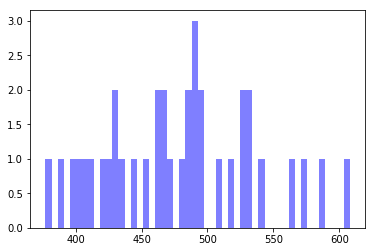

In [181]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
 
x = [ElevationChange.from_nodes(l.nodes()).gain for l in la.candidates(10).loops]
num_bins = 50
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()




In [169]:
class LoopAnalyzer:
    def __init__(self, loop_list: List[Subpath]):
        self.loops = loop_list
    
    def candidates(self, length_target: float, tolerance=1):
        return LoopAnalyzer([loop for loop in loops if abs(loop.distance_km() - length_target) < tolerance])
    
    def minimize_elevation(self):
        return LoopAnalyzer(sorted([l for l in self.loops], key = lambda l: ElevationChange.from_nodes(l.nodes()).gain))

    def maximize_elevation(self):
        return LoopAnalyzer(list(reversed(self.minimize_elevation().loops)))
    
    def __repr__(self):
        return f'LoopAnalyzer: {self.loops[:3].__repr__()}'
la = LoopAnalyzer(loops)

LoopAnalyzer: [4.002165927750376: fakeroot<->unamed<->Clarkia Trail<->unamed<->Sunset Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Sunset Trail<->unamed<->Clarkia Trail<->unamed<->fakeroot, 4.654301666062597: fakeroot<->unamed<->Clarkia Trail<->Clarkia Trail<->Sunset Trail<->Sunset Trail<->Sunset Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Sunset Trail<->unamed<->Clarkia Trail<->unamed<->fakeroot, 4.654301666062062: fakeroot<->unamed<->Clarkia Trail<->unamed<->Sunset Trail<->Edgewood Trail<->Edgewood Trail<->Edgewood Trail<->Sunset Trail<->Sunset Trail<->Sunset Trail<->Clarkia Trail<->Clarkia Trail<->unamed<->fakeroot]

In [177]:
gmap = gmplot.GoogleMapPlotter(37.4684697, -122.2895862, 13)
la.candidates(10.0).maximize_elevation().loops[0].draw(gmap)
gmap.draw('out.html')

In [178]:
!xdg-open 'out.html'

Created new window in existing browser session.


In [143]:
ElevationChange.from_nodes(la.candidates(50.0)[0].nodes())

ElevationChange(gain=1583, loss=1583)

In [132]:
!ls

cache  out.html  trails.ipynb  Untitled1.ipynb	Untitled.ipynb


In [133]:
!ls -a

.   cache		out.html      Untitled1.ipynb
..  .ipynb_checkpoints	trails.ipynb  Untitled.ipynb
